### Import the necessary packages
* matplotlib.pyplot for plotting
* [`OrderedDict`](https://docs.python.org/2/library/collections.html#ordereddict-objects) from collections: "Ordered dictionaries are just like regular dictionaries but they remember the order that items were inserted. When iterating over an ordered dictionary, the items are returned in the order their keys were first added."
* [`torch.nn`](https://pytorch.org/docs/stable/nn.html) for building the neuronal network
* [`torch.nn.optim`](https://pytorch.org/docs/stable/optim.html) to use the optimizer algorithms like SGD or Adam to update the weights.
* [`torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html#) for the neuronal network functions like activation functions, dropout functions etc.
* [`torchvision.datasets`](https://pytorch.org/docs/stable/torchvision/datasets.html) to get different datasets like MNIST, FASHION MINIST, CIFAR etc. 
* [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) to get different neuronal network models like AlexNet, VGG, DensNet, etc.
* [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html) for image transformation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict

import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
import helper

Get the device. The device is either cuda:0 for GPU or CPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Get the data
Get the `MNIST` dataset divided into the trainset and the testset! 

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ),(0.5,))])

trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

See one of the images.

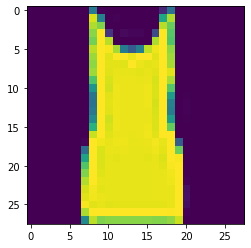

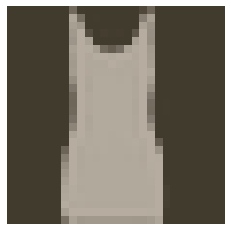

In [4]:
image, label = next(iter(trainloader))
# print(image[0].shape)
a = image[0].numpy()
# print(a)
# print(a[0].shape)
plt.imshow(a[0])
helper.imshow(image[0, :]);

### Build the network
There are two possible ways to build a network: 1. a static one 2. a dynamic one. 
<br>

The dynamic one allows us to configure as many hidden layers as we want just by modifying a patrameter list of the hidden layers. This is done with the help of [`nn.ModuleList`](https://pytorch.org/docs/stable/nn.html#modulelist).

**Option 1: static definition** of the neuronal network by using 
```python
nn.Sequential(OrderedDict([]))
```

In [5]:
# define the hyperparameter
inpot_layer_size = 784
hidden_layer_size = [800, 400, 200, 100, 50]
output_layer_size= 10

netmodel = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(inpot_layer_size, hidden_layer_size[0])),
    ('relu1', nn.ReLU()),
    ('fcl2', nn.Linear(hidden_layer_size[0], hidden_layer_size[1])),
    ('relu2', nn.ReLU()),
    ('fcl3', nn.Linear(hidden_layer_size[1], hidden_layer_size[2])),
    ('relu3', nn.ReLU()),
    ('fcl4', nn.Linear(hidden_layer_size[2], hidden_layer_size[3])),
    ('relu4', nn.ReLU()),
    ('fcl5', nn.Linear(hidden_layer_size[3], hidden_layer_size[4])),
    ('relu5', nn.ReLU()),
    ('out', nn.Linear(hidden_layer_size[4], output_layer_size))
]))

netmodel

Sequential(
  (fcl1): Linear(in_features=784, out_features=800, bias=True)
  (relu1): ReLU()
  (fcl2): Linear(in_features=800, out_features=400, bias=True)
  (relu2): ReLU()
  (fcl3): Linear(in_features=400, out_features=200, bias=True)
  (relu3): ReLU()
  (fcl4): Linear(in_features=200, out_features=100, bias=True)
  (relu4): ReLU()
  (fcl5): Linear(in_features=100, out_features=50, bias=True)
  (relu5): ReLU()
  (out): Linear(in_features=50, out_features=10, bias=True)
)

Option 2: dynamic definition of the neuronal network by using [`nn.ModuleList`](https://pytorch.org/docs/stable/nn.html#modulelist).

In [6]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size, dropout_p = 0.5):
        ''' Builds a feedforward network with arbitrary hidden layers!
        
            Arguments:
            ----------
            input_size: integer, size of the input
            hidden_layers: list of integers, the sizes of the hidden layers
            output_size: integer, size of the output layer
            dropout_p: float between 0 and 1, dropout probability
        '''
        # call the __init()__ function of nn.Module
        super().__init__()
        # Add the first layer -> input to a hidden layer. This is equivalent to 'fcl1' of the static network
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable numbers of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        # Add the output layer
        self.output_layer = nn.Linear(hidden_layers[-1], output_size)
        
        # Define dropout
        self.dropout = nn.Dropout(p = dropout_p)
        
    def forward(self, x):
        ''' Forward pass through the network.
        
            Arguments:
            ---------
            x: torch tensor, input to the network
            
            Return:
            -------
            
        '''
        
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
            
        x = self.output_layer(x)
        
        # return the log_softmax. the log-softmax is a log probability 
        # which comes with a lot of benefits. Using the log probability, 
        # computations are often faster and more accurate.
        return F.log_softmax(x, dim=1)

Function for validating the model

In [7]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    model.to(device)
    
    for images, labels in testloader:
        
        images.resize_(images.shape[0], 784)
        
        images, labels = images.to(device), labels.to(device)
        
        output = model.forward(images)
        
        test_loss += criterion(output, labels).item()
        
#         loss = criterion(output, labels)
#         lest_loss += loss.item()

        # take the exponentiol because the output is in log probability (log_softmax)
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return test_loss, accuracy

### Train the model
Make a single cycle consisting of:
1. **Definition of the loss function**. This is needed to calculate the loss / difference between the result of the forward pass through the network and the true value (=label) -> `criterion = nn.CrossEntropyLoss()`
2. **Definition of the optimizer function**. The optimizer function updates the defined parameters (=weights of the network) -> `optimizer = optim.Adam(netmodel.parameters(), lr=0.01)`
* **Move the model to device** ( this is either the CPU or the GPU) -> `netmodel.to(device)`
* **Get the images and the corresponding labels** -> `images, labels = next(iter(trainloader))`
* **Flatten the images** into an element vector -> `images.resize_(images.size()[0], 784)`
* **Move the torch tensors *images* and *labels* to device** (this is either the CPU or the GPU) -> `images, labels = images.to(device), labels.to(device)`
* **Clear the gradients**. This is necessary because the gradients are accumulated during the backward pass. -> `optimizer.zero_grad()`
* **Forward pass** through the network -> `output = netmodel.forward(images)`
* **Calculate the loss** -> `loss = criterion(output, labels)`
* **Backwards pass** to calculate the gradients  -> `loss.backward()`
* **Update the weights** -> `optimizer.step()`

Select the network - dynamic or static

In [8]:
nnDynamic = True

In [9]:
if nnDynamic == False:
    # define the loss function
    criterion = nn.CrossEntropyLoss()
    # define the optimizer and pass in the network parameters that should be optimized and the learning rate 
    optimizer = optim.Adam(netmodel.parameters(), lr=0.01)
else:
    input_layer_size = 784
    output_layer_size = 10
#     hidden_layers_list = [512, 256, 128, 64]
    hidden_layers_list = [800, 800, 600, 600, 400, 400, 200, 200]
    dropout_p = 0.0
    # create the netmodel
    netmodel = Network(input_layer_size,hidden_layers_list, output_layer_size, dropout_p)
    # define the loss function
    criterion = nn.NLLLoss()
    # define the optimizer and pass in the network parameters that should be optimized and the learning rate 
    optimizer = optim.Adam(netmodel.parameters(), lr=0.003)
netmodel

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=800, bias=True)
    (1): Linear(in_features=800, out_features=800, bias=True)
    (2): Linear(in_features=800, out_features=600, bias=True)
    (3): Linear(in_features=600, out_features=600, bias=True)
    (4): Linear(in_features=600, out_features=400, bias=True)
    (5): Linear(in_features=400, out_features=400, bias=True)
    (6): Linear(in_features=400, out_features=200, bias=True)
    (7): Linear(in_features=200, out_features=200, bias=True)
  )
  (output_layer): Linear(in_features=200, out_features=10, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [10]:
# # define the loss function
# criterion = nn.CrossEntropyLoss()
# # define the optimizer and pass in the network parameters that should be optimized and the learning rate 
# optimizer = optim.Adam(netmodel.parameters(), lr=0.01)

# set the number of epochs. One epoch is a pass through the entire dataset (= training set)
epochs = 4
# print everey 40 steps the averaged loss over these 40 steps
print_every = 40
steps = 0

# move the model to device ( this con be either the CPU or the GPU)
netmodel.to(device)

for e in range(epochs):
    # accumulate the loss
    running_loss = 0
    # iterate over the training set
    for images, labels in iter(trainloader):
        steps += 1
        
        # flatten the image into a 784 (28x28) element vector
        images.resize_(images.size()[0], 784)
        
        # move the torch tensors images and labels to device
        images, labels = images.to(device), labels.to(device)
        
        # Clear the gradients, because backward accumulates the gradients and so they have to be cleared
        optimizer.zero_grad()

        # forward pass through the network
        output = netmodel.forward(images)

        # calculate the loss / error between the output and the true labels
        loss = criterion(output, labels)

        # calculate the gradients
        loss.backward()

        # update the weights
        optimizer.step()
        
        # accumulate the loss / cost
        # loss is a scalar tensor therefore .item() is needed to get the value out of the tensor
        running_loss += loss.item()
    

        if steps % print_every == 0:
            if nnDynamic == True:
                # Make sure network is in eval mode for inference
                netmodel.eval()

                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                    # call validation to validate the model
                    test_loss, accuracy = validation(netmodel, testloader, criterion)

                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Training loss: {:.3f}".format(running_loss/print_every),
                      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

#                 running_loss = 0
                
                # Make sure training is back on
                netmodel.train()
            else:
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Training loss: {:.3f}".format(running_loss/print_every))

            running_loss = 0
            

Epoch: 1/4...  Training loss: 2.078 Test Loss: 1.467..  Test Accuracy: 0.298
Epoch: 1/4...  Training loss: 1.336 Test Loss: 1.477..  Test Accuracy: 0.406
Epoch: 1/4...  Training loss: 1.167 Test Loss: 1.063..  Test Accuracy: 0.549
Epoch: 1/4...  Training loss: 1.010 Test Loss: 0.939..  Test Accuracy: 0.575
Epoch: 1/4...  Training loss: 0.981 Test Loss: 0.969..  Test Accuracy: 0.612
Epoch: 1/4...  Training loss: 0.907 Test Loss: 0.835..  Test Accuracy: 0.670
Epoch: 1/4...  Training loss: 0.810 Test Loss: 0.775..  Test Accuracy: 0.679
Epoch: 1/4...  Training loss: 0.791 Test Loss: 0.772..  Test Accuracy: 0.661
Epoch: 1/4...  Training loss: 0.785 Test Loss: 0.761..  Test Accuracy: 0.696
Epoch: 1/4...  Training loss: 0.823 Test Loss: 0.711..  Test Accuracy: 0.712
Epoch: 1/4...  Training loss: 0.733 Test Loss: 0.733..  Test Accuracy: 0.696
Epoch: 1/4...  Training loss: 0.735 Test Loss: 0.767..  Test Accuracy: 0.699
Epoch: 1/4...  Training loss: 0.705 Test Loss: 0.688..  Test Accuracy: 0.723

/home/horst/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


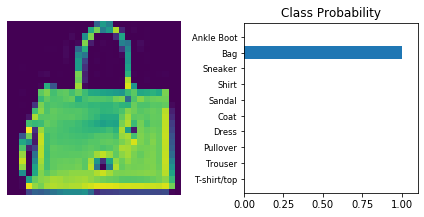

In [11]:
# Test out your network!
netmodel.to('cpu')

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# TODO: Calculate the class probabilities (softmax) for img
ps = F.softmax(netmodel.forward(img))

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps, version='Fashion')